In [4]:
import numpy as np
import random

In [5]:
import random
from typing import List, Optional, Tuple, Union, Sequence

# Third-party libraries
import numpy as np
import test

class Network(object):

    def __init__(self, sizes: List[int]):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a: np.ndarray) -> np.ndarray:
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(
            self, 
            training_data: List[Tuple],
            epochs: int,
            mini_batch_size: int,
            eta: float,  # Learning rate
            test_data: Optional[List[Tuple]] = None
        ):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print(f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")
            else:
                print(f"Epoch {j} complete")
    
    def SGD_from_batch_provider(
        self,
        training_data_provider,
        epochs: int,
        eta: float,  # Learning rate
        test_data_provider = None,
        verbose: bool = False
    ):
        """Consumes a DataProvider object to train the network using mini-batch stochastic
        gradient descent. The DataProvider should yield mini-batches of data.

        Args:
            training_data_provider (DataProvider): mlp.data_providers.DataProvider object
            epochs (int): number of full passes over the training data
            eta (float): learning rate
        """
        for j in range(epochs):
            for mini_batch_inputs, mini_batch_labels in training_data_provider:
                # Convert mini_batch to list of tuples if it's not already
                mini_batch = [ (x.reshape(-1, 1), y.reshape(-1, 1)) for x, y in zip(mini_batch_inputs, mini_batch_labels) ]
                self.update_mini_batch(mini_batch, eta)
            if verbose:
                print(f"Epoch {j} complete")
            if test_data_provider:
                num_correct, num_samples = 0, 0
                for test_batch_inputs, test_batch_labels in test_data_provider:
                    ys = [int(np.argmax(y)) for y in test_batch_labels]
                    test_batch = [ (x.reshape(-1, 1), y) for x, y in zip(test_batch_inputs, ys) ]
                    num_correct += self.evaluate(test_batch)
                    num_samples += len(test_batch)
                if verbose:
                    print(f"Test set performance: {num_correct} / {num_samples}")        

    def update_mini_batch(self, mini_batch: List[Tuple], eta: float):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x: np.ndarray, y: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data: Sequence[Tuple[np.ndarray, Union[np.ndarray, int]]]) -> int:
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if test_data and isinstance(test_data[0][1], np.ndarray):
            # If the test labels are one-hot encoded, convert them to class indices
            test_data = [(x, int(np.argmax(y))) for (x, y) in test_data]
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
    def evaluate_from_data_provider(self, test_data_provider) -> int:
        """Evaluate the network's performance using a DataProvider object.
        The DataProvider should yield mini-batches of data.

        Args:
            test_data_provider (DataProvider): mlp.data_providers.DataProvider object
            
        """
        num_correct = 0
        for test_batch_inputs, test_batch_labels in test_data_provider:
            ys = [int(np.argmax(y)) for y in test_batch_labels]
            test_batch = [ (x.reshape(-1, 1), y) for x, y in zip(test_batch_inputs, ys) ]
            num_correct += self.evaluate(test_batch)
        return num_correct

    def cost_derivative(self, output_activations: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Return the vector of partial derivatives partial C_x /
        partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z: np.ndarray) -> np.ndarray:
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z: np.ndarray) -> np.ndarray:
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [6]:
import mlp.data_providers as data_providers

BATCH_SIZE = 10
NUM_BATCHES = 100

training_data, validation_data, test_data = [data_providers.MNISTDataProvider(
    which_set=set_type, batch_size=BATCH_SIZE, max_num_batches=NUM_BATCHES, shuffle_order=True)
    for set_type in ['train', 'valid', 'test'] ]

In [7]:
network = Network([784, 30, 10])
network.SGD_from_batch_provider(training_data, 30, 3.0, test_data, verbose=True)

Epoch 0 complete
Test set performance: 346 / 1000
Epoch 1 complete
Test set performance: 533 / 1000
Epoch 2 complete
Test set performance: 626 / 1000
Epoch 3 complete
Test set performance: 642 / 1000
Epoch 4 complete
Test set performance: 686 / 1000
Epoch 5 complete
Test set performance: 668 / 1000
Epoch 6 complete
Test set performance: 712 / 1000
Epoch 7 complete
Test set performance: 747 / 1000
Epoch 8 complete
Test set performance: 725 / 1000
Epoch 9 complete
Test set performance: 726 / 1000
Epoch 10 complete
Test set performance: 736 / 1000
Epoch 11 complete
Test set performance: 741 / 1000
Epoch 12 complete
Test set performance: 747 / 1000
Epoch 13 complete
Test set performance: 738 / 1000
Epoch 14 complete
Test set performance: 767 / 1000
Epoch 15 complete
Test set performance: 746 / 1000
Epoch 16 complete
Test set performance: 763 / 1000
Epoch 17 complete
Test set performance: 748 / 1000
Epoch 18 complete
Test set performance: 768 / 1000
Epoch 19 complete
Test set performance: 8

In [8]:
# Check how it did against our evaluation set with raw accuracy
score = network.evaluate_from_data_provider(test_data)
accuracy = score / (NUM_BATCHES * BATCH_SIZE)
print(f"Final accuracy: {accuracy}")

Final accuracy: 0.908


In [9]:
from sklearn.metrics import f1_score

def f1_score_from_data_provider(network, data_provider) -> float:
    """Compute the F1 score of the network using a DataProvider object.
    The DataProvider should yield mini-batches of data.

    Args:
        network (Network): a feedforward network object to evaluate
        data_provider (DataProvider): mlp.data_providers.DataProvider object
    """
    all_preds, all_labels = [], []
    for batch_inputs, batch_labels in data_provider:
        ys = [int(np.argmax(y)) for y in batch_labels]
        batch = [ (x.reshape(-1, 1), y) for x, y in zip(batch_inputs, ys) ]
        test_results = [(np.argmax(network.feedforward(x)), y) for (x, y) in batch]
        preds, labels = zip(*test_results)
        all_preds.extend(preds)
        all_labels.extend(labels)
    score = f1_score(all_labels, all_preds, average='weighted')
    if not isinstance(score, float):
        raise ValueError("F1 Score calculator did not return a float.")
    return score

In [10]:
# Let's also examine the f1 score
score = f1_score_from_data_provider(network, test_data)
print(f"Final F1 score: {score}")

Final F1 score: 0.896946142742713


In [11]:
# Now let's try a deeper network and see if it improves!
EPOCHS = 100
BATCH_SIZE = 10
NUM_BATCHES = 100
LEARNING_RATE = 0.5

FIRST_LAYER = 80
SECOND_LAYER = 30

# Don't change this
INPUT_NEURONS = 784
OUTPUT_LABELS = 10

training_data, validation_data, test_data = [data_providers.MNISTDataProvider(
    which_set=set_type, batch_size=BATCH_SIZE, max_num_batches=NUM_BATCHES, shuffle_order=True)
    for set_type in ['train', 'valid', 'test'] ]

two_layer_network = Network([INPUT_NEURONS, FIRST_LAYER, SECOND_LAYER, OUTPUT_LABELS])
two_layer_network.SGD_from_batch_provider(training_data, EPOCHS, LEARNING_RATE, test_data, verbose=False)

In [12]:
score = two_layer_network.evaluate_from_data_provider(test_data)
accuracy = score / (NUM_BATCHES * BATCH_SIZE)
print(f"Final accuracy: {accuracy}")

score = f1_score_from_data_provider(two_layer_network, test_data)
print(f"Final F1 score: {score}")

Final accuracy: 0.903
Final F1 score: 0.8841073314266595


In [13]:
# Now let's run a sweep for fun
learning_rates = [0.01, 1, 3]
batch_sizes = [8, 20]
first_layer_neuron_counts = [10, 30]
second_layer_neuron_counts = [10, 30]

run = 0
runs = []
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for fl_neurons in first_layer_neuron_counts:
            for sl_neurons in second_layer_neuron_counts:
                run += 1
                runs.append([learning_rate, batch_size, fl_neurons, sl_neurons, 0, 0])
                
                # Load the data
                training_data, validation_data, test_data = [data_providers.MNISTDataProvider(
                    which_set=set_type, batch_size=batch_size, max_num_batches=NUM_BATCHES, shuffle_order=True)
                    for set_type in ['train', 'valid', 'test'] ]
                
                # Train the network
                print(f"Running {run} | eta = {learning_rate}, batch size = {batch_size}, neurons: {fl_neurons}-{sl_neurons}")
                network = Network([INPUT_NEURONS, fl_neurons, sl_neurons, OUTPUT_LABELS])
                network.SGD_from_batch_provider(training_data, EPOCHS, LEARNING_RATE, test_data, verbose=False)
                
                # Score and present results
                score = network.evaluate_from_data_provider(test_data)
                accuracy = score / (NUM_BATCHES * batch_size)
                print(f"Final accuracy for run {run}: {accuracy}")
                score = f1_score_from_data_provider(network, test_data)
                print(f"Final F1 score for run {run}: {score}")
                runs[-1][-2] = accuracy
                runs[-1][-1] = score


                

Running 1 | eta = 0.01, batch size = 8, neurons: 10-10
Final accuracy for run 1: 0.85875
Final F1 score for run 1: 0.8382328071391595
Running 2 | eta = 0.01, batch size = 8, neurons: 10-30
Final accuracy for run 2: 0.8675
Final F1 score for run 2: 0.8595682120827134
Running 3 | eta = 0.01, batch size = 8, neurons: 30-10
Final accuracy for run 3: 0.86
Final F1 score for run 3: 0.835175824540126
Running 4 | eta = 0.01, batch size = 8, neurons: 30-30
Final accuracy for run 4: 0.89625
Final F1 score for run 4: 0.8780150500877549
Running 5 | eta = 0.01, batch size = 20, neurons: 10-10
Final accuracy for run 5: 0.85
Final F1 score for run 5: 0.8501805307254695
Running 6 | eta = 0.01, batch size = 20, neurons: 10-30
Final accuracy for run 6: 0.7745
Final F1 score for run 6: 0.7471759308487946
Running 7 | eta = 0.01, batch size = 20, neurons: 30-10
Final accuracy for run 7: 0.861
Final F1 score for run 7: 0.8566121694119662
Running 8 | eta = 0.01, batch size = 20, neurons: 30-30
Final accuracy

Top 10 by accuracy (no pandas available):
{'Learning Rate': 0.01, 'Batch Size': 8, 'First Layer Neurons': 30, 'Second Layer Neurons': 30, 'Accuracy': 0.89625, 'F1 Score': 0.8780150500877549}
{'Learning Rate': 0.01, 'Batch Size': 20, 'First Layer Neurons': 30, 'Second Layer Neurons': 30, 'Accuracy': 0.89, 'F1 Score': 0.8750007772457524}
{'Learning Rate': 3, 'Batch Size': 8, 'First Layer Neurons': 30, 'Second Layer Neurons': 30, 'Accuracy': 0.8875, 'F1 Score': 0.8628860847879399}
{'Learning Rate': 1, 'Batch Size': 20, 'First Layer Neurons': 30, 'Second Layer Neurons': 30, 'Accuracy': 0.884, 'F1 Score': 0.8788592874979686}
{'Learning Rate': 1, 'Batch Size': 8, 'First Layer Neurons': 30, 'Second Layer Neurons': 30, 'Accuracy': 0.875, 'F1 Score': 0.8858996533418625}
{'Learning Rate': 3, 'Batch Size': 20, 'First Layer Neurons': 30, 'Second Layer Neurons': 30, 'Accuracy': 0.875, 'F1 Score': 0.8722135458220457}
{'Learning Rate': 1, 'Batch Size': 20, 'First Layer Neurons': 30, 'Second Layer Neu

/var/folders/76/vhhlcd3s7n55pbsj6t9d3j_80000gn/T/ipykernel_64016/800124215.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


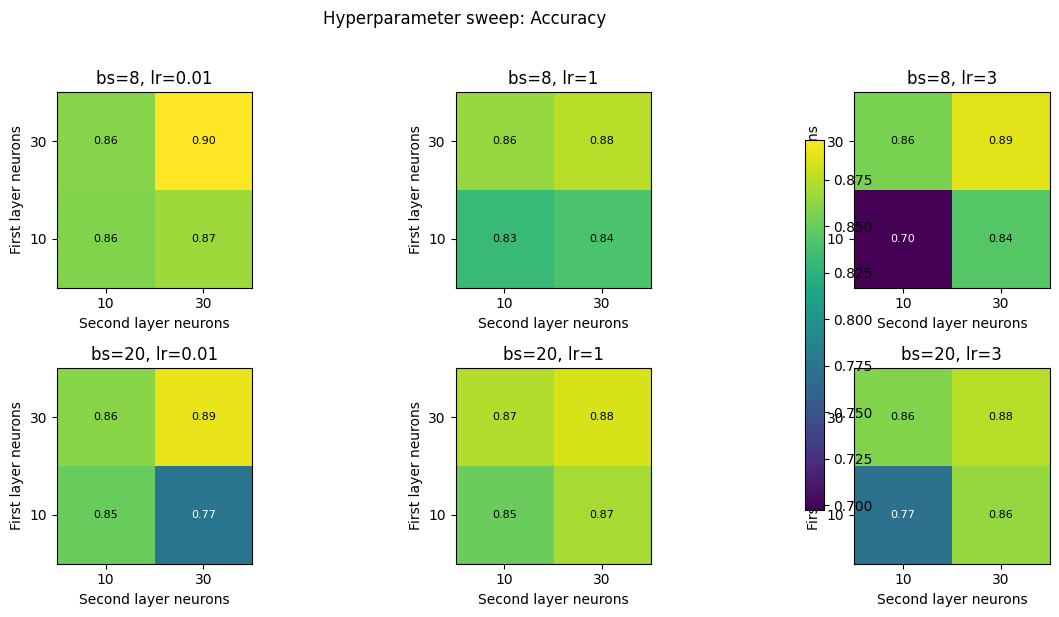

/var/folders/76/vhhlcd3s7n55pbsj6t9d3j_80000gn/T/ipykernel_64016/800124215.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


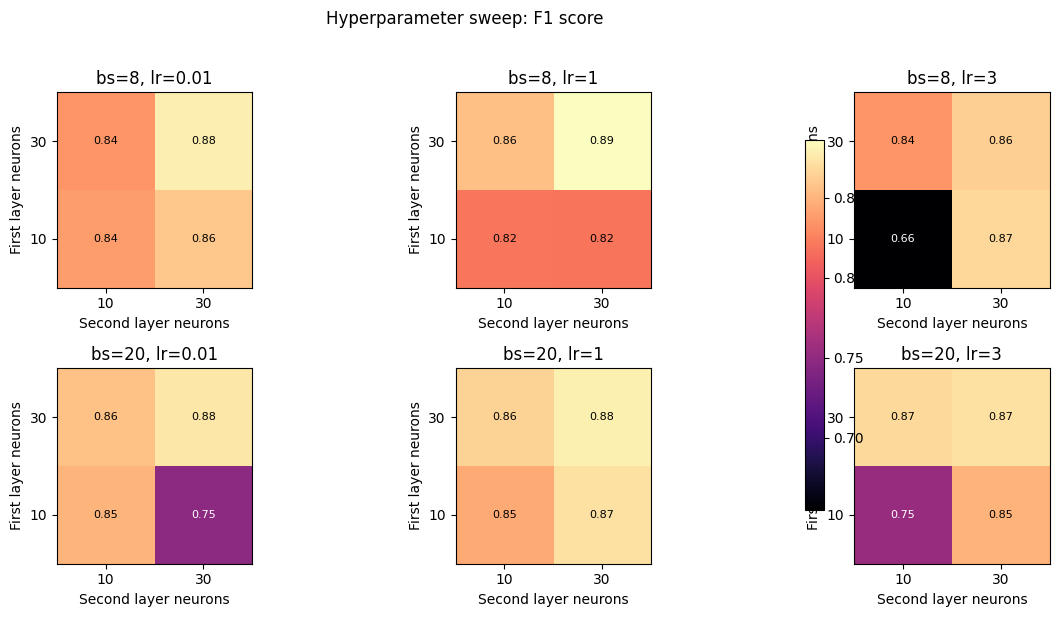

In [14]:
# Plot hyperparameter sweep results
import numpy as np
import matplotlib.pyplot as plt
try:
    import pandas as pd
    import seaborn as sns
    _HAS_PANDAS = True
except Exception:
    _HAS_PANDAS = False

cols = ['Learning Rate', 'Batch Size', 'First Layer Neurons', 'Second Layer Neurons', 'Accuracy', 'F1 Score']
if _HAS_PANDAS:
    results_df = pd.DataFrame(runs, columns=cols)
    display(results_df.sort_values('Accuracy', ascending=False).head(10))
else:
    # Fallback simple print
    print('Top 10 by accuracy (no pandas available):')
    for r in sorted(runs, key=lambda x: x[4], reverse=True)[:10]:
        print(dict(zip(cols, r)))

# Heatmaps over (First, Second) layer sizes per (batch size, learning rate)
lrs = sorted({r[0] for r in runs})
bss = sorted({r[1] for r in runs})
fls = sorted({r[2] for r in runs})
sls = sorted({r[3] for r in runs})

def grid_for(metric_index):
    grids = {}
    for bs in bss:
        for lr in lrs:
            G = np.full((len(fls), len(sls)), np.nan)
            for lr_, bs_, fl, sl, acc, f1 in runs:
                if lr_ == lr and bs_ == bs:
                    i = fls.index(fl); j = sls.index(sl)
                    G[i, j] = [acc, f1][metric_index-4]
            grids[(bs, lr)] = G
    return grids

acc_grids = grid_for(metric_index=4)
f1_grids  = grid_for(metric_index=5)

def plot_grids(grids, title, cmap):
    vmin = np.nanmin([np.nanmin(g) for g in grids.values()])
    vmax = np.nanmax([np.nanmax(g) for g in grids.values()])
    fig, axes = plt.subplots(len(bss), len(lrs), figsize=(4*len(lrs), 3*len(bss)), squeeze=False)
    for i, bs in enumerate(bss):
        for j, lr in enumerate(lrs):
            ax = axes[i, j]
            G = grids[(bs, lr)]
            im = ax.imshow(G, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
            ax.set_xticks(range(len(sls))); ax.set_xticklabels(sls)
            ax.set_yticks(range(len(fls))); ax.set_yticklabels(fls)
            ax.set_xlabel('Second layer neurons')
            ax.set_ylabel('First layer neurons')
            ax.set_title(f'bs={bs}, lr={lr}')
            for ii in range(len(fls)):
                for jj in range(len(sls)):
                    v = G[ii, jj]
                    if np.isfinite(v):
                        ax.text(jj, ii, f'{v:.2f}', ha='center', va='center', color='white' if v < (vmin+vmax)/2 else 'black', fontsize=8)
    fig.colorbar(im, ax=axes, shrink=0.8, location='right')
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

plot_grids(acc_grids, 'Hyperparameter sweep: Accuracy', cmap='viridis')
plot_grids(f1_grids,  'Hyperparameter sweep: F1 score', cmap='magma')


In [ ]:
# Note that our model is generally learning positionally invariant edges / component shapes
# We probably have a somewhat hard maximum score because some of the numbers just don't have sufficient components in the same
# exact part of the screen as the others.
# If only we could introduce the ability to naturally translate the image to a location that maximizes the existing inference
# We'd need to introduce a mechanic that could shift the image in small increments and re-evaluate the network to see if it improves the score
# It would operate like an eyeball centering the image until the number is optimally positioned
# This would be a form of attention mechanism, but a very simple one
# Below is an example of how we might do that in the network class
# However, this is computationally expensive and not typically how neural networks are used
# It is more of a thought experiment to illustrate the concept of attention mechanisms
def evaluate_with_attention(self, network, test_data: Sequence[Tuple[np.ndarray, Union[np.ndarray, int]]]):
    # Conduct initial inference of the test data
    if test_data and isinstance(test_data[0][1], np.ndarray):
        # If the test labels are one-hot encoded, convert them to class indices
        test_data = [(x, int(np.argmax(y))) for (x, y) in test_data]
    test_results = []
    for (x, y) in test_data:
        score_vector = network.feedforward(x)
        # Check 8 slight translations (diagonal, horizontal, vertical) of x and check if 
        # any predictions increase a weighted sum of probabilities
        # so long as we stay below a threshold of confidence.
        
        # if the prediction increases, re-translate and re-evaluate until we overcome our confidence threshold with
        # any particular prediction

        # Add the best performing prediction to our results
        test_results.append((np.argmax(score_vector), y))
    test_results = (np.argmax(network.feedforward(x)), y)
                    for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)

In [ ]:
# Attention-style evaluation: try translated inputs until reaching a confidence threshold
import numpy as np
from typing import Iterable, Sequence, Tuple, Union

def softmax_vec(z: np.ndarray) -> np.ndarray:
    z = z.reshape(-1)
    z = z - np.max(z)
    e = np.exp(z)
    return e / np.sum(e)

def shift_image_column(x_col: np.ndarray, dx: int, dy: int) -> np.ndarray:
    img = x_col.reshape(28, 28)
    out = np.zeros_like(img)
    xs_src_start = max(0, -dx); xs_src_end = min(28, 28 - dx)
    ys_src_start = max(0, -dy); ys_src_end = min(28, 28 - dy)
    if xs_src_start < xs_src_end and ys_src_start < ys_src_end:
        xs_dst_start = xs_src_start + dx
        ys_dst_start = ys_src_start + dy
        out[ys_dst_start:ys_dst_start+(ys_src_end-ys_src_start),
            xs_dst_start:xs_dst_start+(xs_src_end-xs_src_start)] = \
        img[ys_src_start:ys_src_end, xs_src_start:xs_src_end]
    return out.reshape(784, 1)

def attention_predict(network, x_col: np.ndarray,
                      shifts: Iterable[Tuple[int, int]] = None,
                      threshold: float = 0.9) -> Tuple[int, float, Tuple[int, int]]:
    if shifts is None:
        rng = range(-2, 3)
        # center first
        shifts = [(0,0)] + [(dx, dy) for dx in rng for dy in rng if not (dx==0 and dy==0)]
    best_conf, best_pred, best_shift = -1.0, -1, (0, 0)
    for (dx, dy) in shifts:
        x_t = shift_image_column(x_col, dx, dy)
        a = network.feedforward(x_t)
        p = softmax_vec(a)
        pred = int(np.argmax(p)); conf = float(p[pred])
        if conf > best_conf:
            best_conf, best_pred, best_shift = conf, pred, (dx, dy)
        if conf >= threshold:
            return best_pred, best_conf, best_shift
    return best_pred, best_conf, best_shift

def evaluate_with_attention(network,
                            test_data: Sequence[Tuple[np.ndarray, Union[np.ndarray, int]]],
                            threshold: float = 0.9,
                            shifts: Iterable[Tuple[int,int]] = None) -> Tuple[int, int]:
    correct, total = 0, 0
    for x, y in test_data:
        y_int = int(np.argmax(y)) if isinstance(y, np.ndarray) else int(y)
        pred, conf, shift = attention_predict(network, x, shifts=shifts, threshold=threshold)
        correct += int(pred == y_int); total += 1
    return correct, total

def evaluate_with_attention_from_provider(network, test_provider, threshold: float = 0.9, shifts: Iterable[Tuple[int,int]] = None) -> Tuple[int, int]:
    correct, total = 0, 0
    for xb, yb in test_provider:
        ys = [int(np.argmax(y)) for y in yb]
        for x_row, y_int in zip(xb, ys):
            x = x_row.reshape(-1, 1)
            pred, conf, shift = attention_predict(network, x, shifts=shifts, threshold=threshold)
            correct += int(pred == y_int); total += 1
    return correct, total


SyntaxError: unexpected character after line continuation character (1625048729.py, line 20)

In [16]:
# Demo: evaluate with attention against test_data provider
# Choose the most recently defined model if available
model = globals().get('two_layer_network', globals().get('network', None))
if model is None:
    raise RuntimeError('No model found. Train a model named `network` or `two_layer_network` first.')
# Ensure test_data provider exists
try:
    test_provider = test_data
except NameError:
    raise RuntimeError('`test_data` provider not found. Run the earlier data-loading cell.')

# Baseline (no attention)
base_correct = model.evaluate_from_data_provider(test_provider)
total = sum(b for b in [0])  # placeholder to use variable below
total = 0
for _, yb in test_provider:
    total += len(yb)
# Re-create iterator (provider resets automatically when exhausted)
att_correct, att_total = evaluate_with_attention_from_provider(model, test_provider, threshold=0.9)
print(f'Baseline accuracy: {base_correct/total:.3f}  ({base_correct}/{total})')
print(f'Attention accuracy: {att_correct/att_total:.3f} ({att_correct}/{att_total})')


NameError: name 'evaluate_with_attention_from_provider' is not defined

In [ ]:
# Refined attention: better confidence, gating, and minimal harm
import numpy as np
from typing import Iterable, Sequence, Tuple, Union

def _inverse_sigmoid(a: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    # Map activations in (0,1) back to logits z via log(a/(1-a))
    a = np.clip(a, eps, 1.0-eps)
    return np.log(a/(1.0-a))

def _conf_metrics(a: np.ndarray, mode: str = 'softmax_logit') -> float:
    # a is (K,1) sigmoid outputs from network
    a = a.reshape(-1,1)
    if mode == 'activation_max':
        return float(np.max(a))
    # Default: convert to logits, then softmax for proper probabilities
    z = _inverse_sigmoid(a)
    z = (z - np.max(z))
    p = np.exp(z); p /= np.sum(p)
    if mode == 'softmax_logit':
        return float(np.max(p))
    if mode == 'margin':
        top2 = np.sort(p.reshape(-1))[-2:]
        return float(top2[-1] - top2[-2])
    if mode == 'entropy':
        q = p.reshape(-1)
        return float(-np.sum(q*np.log(q+1e-12)))
    raise ValueError('Unknown mode')

def shift_image_column(x_col: np.ndarray, dx: int, dy: int, padding: str = 'zero') -> np.ndarray:
    img = x_col.reshape(28, 28)
    if padding == 'zero':
        out = np.zeros_like(img)
        xs_src_start = max(0, -dx); xs_src_end = min(28, 28 - dx)
        ys_src_start = max(0, -dy); ys_src_end = min(28, 28 - dy)
        if xs_src_start < xs_src_end and ys_src_start < ys_src_end:
            xs_dst_start = xs_src_start + dx; ys_dst_start = ys_src_start + dy
            out[ys_dst_start:ys_dst_start+(ys_src_end-ys_src_start),
                xs_dst_start:xs_dst_start+(xs_src_end-xs_src_start)] = img[ys_src_start:ys_src_end, xs_src_start:xs_src_end]
        return out.reshape(784,1)
    elif padding == 'edge':
        # replicate edge pixels instead of zeros
        out = np.pad(img, 1, mode='edge')
        # Shift inside padded then crop back
        y0 = 1+dy; x0 = 1+dx
        out2 = np.zeros_like(img)
        out2[:, :] = out[y0:y0+28, x0:x0+28]
        return out2.reshape(784,1)
    else:
        raise ValueError('Unknown padding')

def attention_predict(network, x_col: np.ndarray, shifts: Iterable[Tuple[int,int]] = None, threshold: float = 0.9, delta: float = 0.02, metric: str = 'softmax_logit', padding: str = 'zero') -> Tuple[int, float, Tuple[int,int]]:
    # Evaluate center first
    a0 = network.feedforward(x_col)
    center_pred = int(np.argmax(a0))
    center_conf = _conf_metrics(a0, mode=metric)
    if center_conf >= threshold:
        return center_pred, center_conf, (0,0)
    # Search neighborhood
    if shifts is None:
        rng = range(-2,3)
        shifts = [(dx,dy) for dx in rng for dy in rng]
    best_pred, best_conf, best_shift = center_pred, center_conf, (0,0)
    for dx, dy in shifts:
        if dx==0 and dy==0: continue
        x_t = shift_image_column(x_col, dx, dy, padding=padding)
        a = network.feedforward(x_t)
        conf = _conf_metrics(a, mode=metric)
        pred = int(np.argmax(a))
        if conf > best_conf:
            best_pred, best_conf, best_shift = pred, conf, (dx,dy)
        if best_conf >= threshold:
            break
    # Only switch if confidence improved meaningfully
    if best_conf >= center_conf + delta:
        return best_pred, best_conf, best_shift
    else:
        return center_pred, center_conf, (0,0)

def evaluate_with_attention_from_provider(network, test_provider, threshold: float = 0.9, delta: float = 0.02, metric: str = 'softmax_logit', padding: str = 'zero') -> Tuple[int,int]:
    correct = total = 0
    for xb, yb in test_provider:
        ys = [int(np.argmax(y)) for y in yb]
        for x_row, y_int in zip(xb, ys):
            x = x_row.reshape(-1,1)
            pred, conf, shift = attention_predict(network, x, threshold=threshold, delta=delta, metric=metric, padding=padding)
            correct += int(pred == y_int); total += 1
    return correct, total


In [ ]:
# Experiments: compare naive vs refined attention on a non-shuffled test provider
model = globals().get('two_layer_network', globals().get('network', None))
assert model is not None, 'Train a model named `network` or `two_layer_network` first.'
import mlp.data_providers as data_providers
B = globals().get('BATCH_SIZE', 10); N = globals().get('NUM_BATCHES', 100)
test_ns = data_providers.MNISTDataProvider('test', batch_size=B, max_num_batches=N, shuffle_order=False)

# Baseline
base_correct = model.evaluate_from_data_provider(test_ns)
total = 0
for _, yb in test_ns: total += len(yb)
print(f'Baseline: {base_correct/total:.3f} ({base_correct}/{total})')

# Naive attention (earlier behavior): softmax over sigmoid, no delta gating
def _naive_attention_predict(network, x_col):
    best_conf, best_pred = -1.0, -1
    for dx in range(-2,3):
        for dy in range(-2,3):
            x_t = shift_image_column(x_col, dx, dy, padding='zero')
            a = network.feedforward(x_t)
            z = a.reshape(-1); z = z - np.max(z); p = np.exp(z); p /= np.sum(p)
            pred = int(np.argmax(p)); conf = float(p[pred])
            if conf > best_conf: best_conf, best_pred = conf, pred
    return best_pred

naive_correct = 0; total2 = 0
for xb, yb in test_ns:
    ys = [int(np.argmax(y)) for y in yb]
    for x_row, y_int in zip(xb, ys):
        x = x_row.reshape(-1,1)
        pred = _naive_attention_predict(model, x)
        naive_correct += int(pred == y_int); total2 += 1
print(f'Naive attention: {naive_correct/total2:.3f} ({naive_correct}/{total2})')

# Refined attention variants
for metric in ['activation_max','softmax_logit','margin']:
    for padding in ['zero','edge']:
        att_c, att_t = evaluate_with_attention_from_provider(model, test_ns, threshold=0.9, delta=0.02, metric=metric, padding=padding)
        print(f'Refined [{metric} | {padding}] : {att_c/att_t:.3f} ({att_c}/{att_t})')
